# <span style="color:blue">Aprendizaje Automático</span>

## Integrantes:
- Daniel Roman Ramirez
- Obed Ríos-Ruiz

# Contexto de los datos

Los datos con los que se cuenta es el conjunto de salidas de múltiples sensores asociadas a un enfriador de un horno de cemento para una ventana temporal dada. El nivel de detalle de la información es entregado con una frecuencia temporal de $1$ minuto para $31$ variables numéricas del proceso.

## 1. Recopilación de datos
A continuación se comenta del proceso de recopilación de datos para la posible construcción de un proceso productivo que consuma esta fuente de información

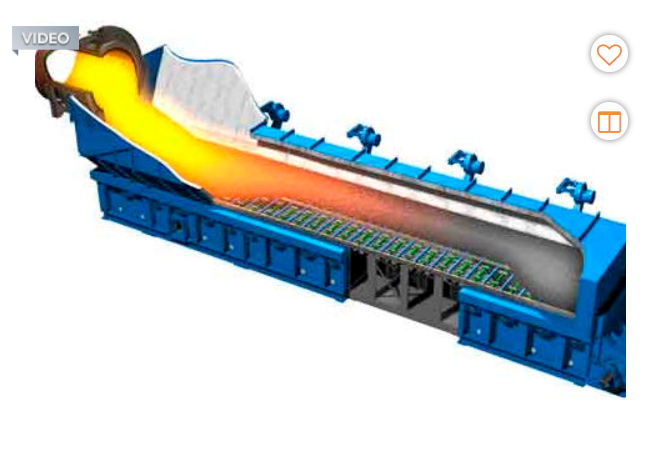

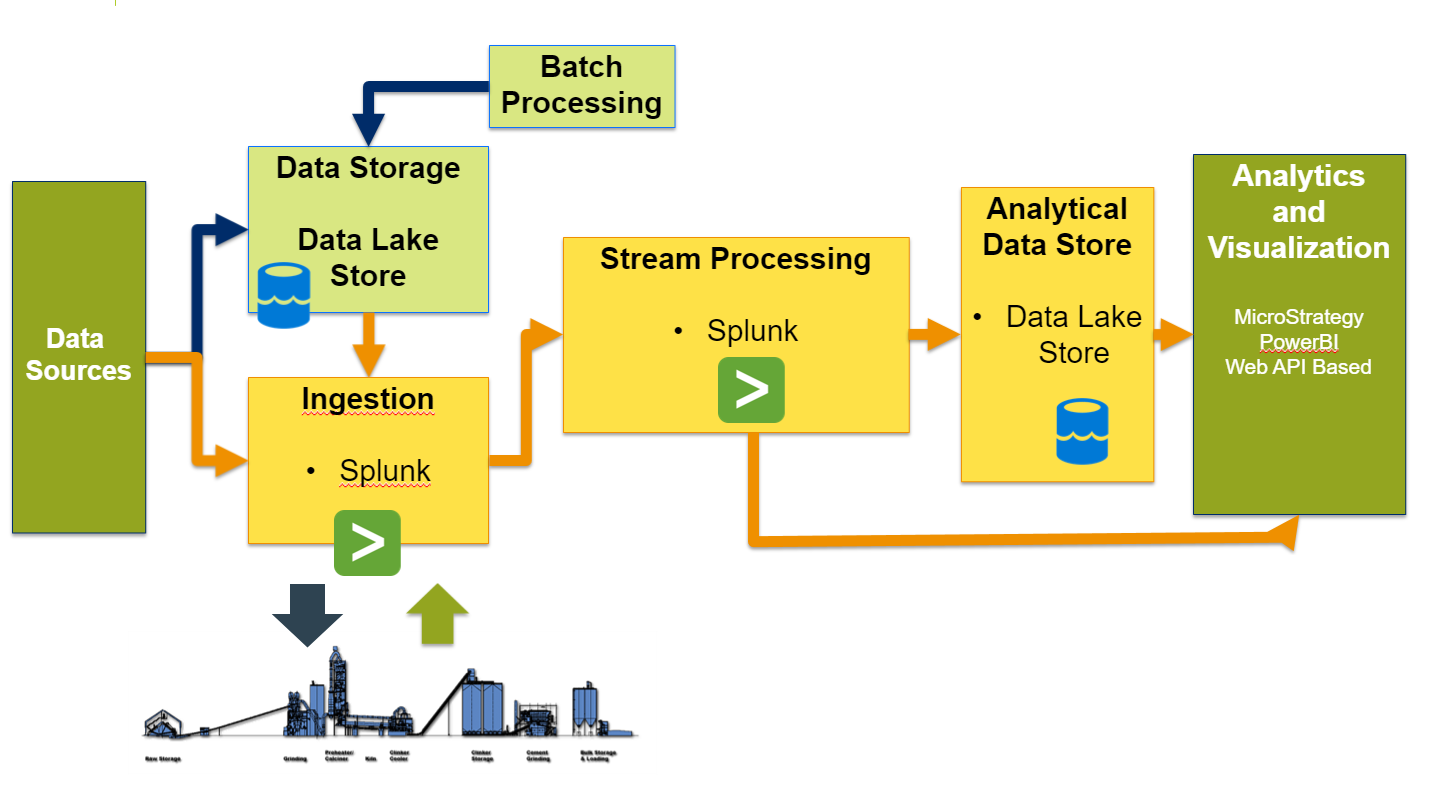

En el diagrama de arquitectura previo se tiene un flujo de datos en el cual las plantas de producción cementera reportan, por medio de servidores y puertos, sus medidas a un punto de conexión [Splunk](https://www.splunk.com/), el cual es un producto que permite capturar, indexar y procesar datos en tiempo real.

### 1.1. Extracción de datos

Para efectos de testeo se entrega una muestra de datos de uno de los componentes de una de las plantas monitoreadas, en particular el **Enfriador_RC**, el cual regula la temperatura del clinker, materia prima para la producción de cemento, a la salida de un horno. Dicha muestra es entregada en formato de archivo plano con extensión <tt>csv</tt>; no obstante, en caso de construirse un modelo que responda a la variable de control, éste podría, sin inconvenientes, incluirse en el flujo de transformación de datos de <tt>Splunk</tt>.

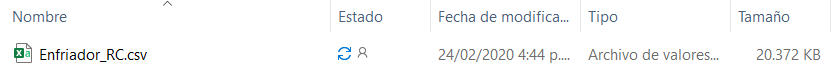

### 1.2. Resumen datos

Para la muestra a disposición, la cual contiene un intervalo temporal de $29$ días, desde el $12/11/2019$ al $11/12/2019$ con una frecuencia minuto a minuto se tiene

<table>
  <tr>
    <th>Descripción general</th>
    <th>Nombre base</th>
    <th>Formato</th>
    <th>Cantidad de columnas</th>
    <th>Cantidad de filas</th>
    <th>Cantidad de variables categorías</th>
    <th>Cantidad de variables numéricas</th>
    <th>Cantidad de variables temporales</th>    
  </tr>
  <tr>
    <td>Información enfriador</td>
    <td>Enfriador_RC</td>
    <td>csv</td>
    <td>33</td>
    <td>43.160</td>
    <td>0</td>
    <td>32</td>
    <td>1</td>    
  </tr>
</table>

### 1.3. Metadata

| Campo           	| Descripción                                                                   	|
|-----------------	|-------------------------------------------------------------------------------	|
| Alimentacion    	| Alimentacion Total (Tn/Hora Harina)                                           	|
| CFN_x           	| Caudal Fan Normal (M3/H) _X Marcacion                                         	|
| CFT             	| Caudal Fan Total                                                              	|
| Fcapa           	| Relacion Presion De Capa Sobre El Objetivo De Presion De Capa                 	|
| Iparilla1       	| Corriente Parrilla 1                                                          	|
| Iparilla2       	| Corriente Parrilla 2                                                          	|
| Iparrilla_obj   	| Corriente Parrilla Obj -- Parámetro                                           	|
| NOx             	| Medida Oxido Nitroso (Parte Por Millon)                                       	|
| O2              	| Medida Oxigeno En El Horno                                                    	|
| PFN300          	| Presion Ventilador 300                                                        	|
| PFN305          	| Presion Ventilador 305                                                        	|
| Pcapa           	| Presion Capa (Mb)                                                             	|
| Pcapa_obj       	| Presion Capa (Mb) Objetivo --- Parámetro                                      	|
| Pcapota         	| Presion Capota                                                                	|
| RACK            	| Relacion Aire-Clinker (M3/Kg Clinker) --- Parámetro                           	|
| TaireSec1       	| Temperatura Aire Secundario 1                                                 	|
| TaireSec2       	| Temperatura Aire Secundario 2                                                 	|
| TaireSec2_obj   	| Temperatura Aire Secundario 2 Objetivo -- Parámetro                           	|
| TinFilter       	| Temperarura Wentreadndo Al Filtro                                             	|
| Tparrilla1      	| Temperatura Parrilla 1                                                        	|
| Tparrilla2      	| Temperatura Parrilla 2                                                        	|
| TsalidaE        	| Temp Salida Enfriador                                                         	|
| Vtiro           	| Velocidad Ventilador Tiro (% Resoecto A Vel Max Ventilador) / Ppal Horno      	|
| VTiroExitCooler 	| Velocidad Ventilador Tiro (% Resoecto A Vel Max Ventilador) /Salida Enfriador 	|
| Vhorno          	| Velocidad De Giro Del Horno (Rpm)                                             	|
| Vparrilla       	| Velocidad Parrilla 1/2 (% Respecto A Vel Maxima)                              	|

93 R2
20° C predición

## 2. Características

### 2.1. Caso de negocio

Al equipo de planta le interesa obtener estimaciones futuras de la temperatura del enfriador $TaireSec2$ a partir de las medidas obtenidas de los sensores anexos al sistema. Se expone una restricción sobre la salida y es que debe tener significado fisico para el sistema, de forma que se pueda tomar como variable de control

## 3. Aprendizaje Supervisado

### 3.1. Data Cleaning

In [1]:
from IPython.display import display, HTML

In [2]:
%matplotlib inline

In [3]:
import os

from pathlib import Path

In [77]:
import time
import json
import sqlite3

import logging
import logging.config
from logging.handlers import RotatingFileHandler

import pandas as pd
import datetime as dt
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt

from sklearn import  preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.utils.validation import column_or_1d

pd.options.display.max_columns = None

In [5]:
def setup_logging(default_path='logging_config.json',
                  default_level=logging.INFO, env_key='LOG_CFG'):
    """
    Setup logging configuration
    """
    
    path = Path(default_path)
    value = os.getenv(env_key, None)
    if value:
        print(f"Using configuration from environment variable {env_key}")
        path = value
    if path.exists():
        with open(path, 'r') as f:
            config = json.load(f)
        print(f"Using logging configuration from {path}")
        logging.config.dictConfig(config)
    else:
        print(f"Using basic logging configuration")
        logging.basicConfig(level=default_level)

In [47]:
def carga_model(base_path, path_savs, sav_name):
    ext = 'sav'
    f_name = f"{sav_name}.{ext}"
    
    f_path = os.path.join(base_path, path_savs, f_name)
    
    samples = {'path' : f_path}
    
    try:
        if not os.path.isfile(f_path):
            logger.error(f"File {f_path} does not exist")            
            raise Exception('non-existing file')
            
        loaded_model = joblib.load(f_path)
        samples['model'] = loaded_model
            
    except Exception as e:
        logger.error(f"Falla en base de datos {f_path}: " + str(e))    
       
    return samples

In [54]:
def save_sqlite(base_path, file_path, data, sqlite_name, table_name):
    ext = 'sqlite3'    
    f_name = f'{sqlite_name}.{ext}'
    
    sample_f_path = os.path.join(base_path, file_path, f'{f_name}')
    con  = sqlite3.connect(sample_f_path)
    logger.info(f"Saving results en {sample_f_path}")    
    
    data.to_sql(table_name, con, if_exists = 'append', index = False)
    
    con.close()
    
    return None

In [6]:
dir_str = r'C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte'
base_path = Path(dir_str)
projekt = '0. Bitacora\Master\CM0891\CM0891'

base_rute = os.path.join(base_path, projekt)

In [7]:
setup_logging(os.path.join(base_path, projekt, "logs/logging_config.json"))
logger = logging.getLogger()
logger.info("Setting up log configuration")

INFO:root:Setting up log configuration


Using basic logging configuration


In [8]:
now_date = dt.datetime.now()

In [9]:
data_source = 'ds3_DIGITAL'

f_file = 'Enfriador_RC'
f_ext = 'csv'

f_path = os.path.join(base_path, projekt, 'data_sources', data_source, 'data', f'{f_file}.{f_ext}')

In [10]:
base_data = pd.read_csv(f_path, sep = ',', encoding = 'UTF-8', decimal = '.')

In [11]:
base_data.dtypes

Alimentacion       float64
CFN300             float64
CFN305             float64
CFN310             float64
CFN315             float64
CFN320             float64
CFN325             float64
CFT                float64
Fcapa              float64
Iparrilla1         float64
Iparrilla2         float64
Iparrilla_obj      float64
NOx                float64
O2                 float64
PFN300             float64
PFN305             float64
Pcapa              float64
Pcapa_obj          float64
Pcapota            float64
RACK               float64
TaireSec1          float64
TaireSec2          float64
TaireSec2_obj      float64
TinFilter          float64
Torque             float64
Tparrila1          float64
Tparrila2          float64
TsalidaE           float64
VTiro              float64
VTiroExitCooler    float64
Vhorno             float64
Vparrilla          float64
_time               object
dtype: object

In [12]:
# Remove first row, which has no data at all
base_data = base_data.iloc[1:]

In [13]:
# Setting time config
base_data['_time'] = pd.to_datetime(base_data['_time'])
base_data['_time'] = base_data['_time'].apply(lambda x: x - x.utcoffset()).apply(lambda x: x.replace(tzinfo=None))
base_data = base_data.set_index('_time', drop = True)

In [14]:
# Data description

desc_base = base_data.describe(include = 'all')
desc_base.loc['dtype'] = base_data.dtypes
desc_base.loc['size'] = len(base_data)
desc_base.loc['% count'] = base_data.isnull().mean()

desc_base.T

,count,mean,std,min,25%,50%,75%,max,dtype,size,% count
Alimentacion,40907,111.076,45.414,2.66152e-38,99.6491,134.862,139.836,145.852,float64,43160,0.0522011
CFN300,42892,251.435,108.85,5.38382,299.286,299.934,300.385,311.628,float64,43160,0.00620945
CFN305,42892,309.365,74.9938,146.21,341.35,349.268,351.004,454.375,float64,43160,0.00620945
CFN310,42892,291.018,124.22,41.5253,345.993,355.943,360.573,399.294,float64,43160,0.00620945
CFN315,42892,251.724,95.7931,61.9004,281.183,290.698,302.51,449.193,float64,43160,0.00620945
CFN320,42892,351.706,130.503,103.643,394.349,401.426,416.805,500.727,float64,43160,0.00620945
CFN325,42892,478.02,31.9047,85.6598,473.86,484.368,492.494,560.344,float64,43160,0.00620945
CFT,42892,1933.27,526.376,768.915,2146.32,2191.28,2217.79,2424.61,float64,43160,0.00620945
Fcapa,42891,0.790514,0.330178,0.118736,0.764762,0.955637,0.997276,1.19667,float64,43160,0.00623262
Iparrilla1,42892,18.1058,9.52893,-0.591338,16.8671,21.0942,23.7514,53.8382,float64,43160,0.00620945


In [15]:
# No functional data - set at 50% null data -  entire columns

to_drop = desc_base.T.reset_index(drop = False).rename(columns = {'index' : 'cols'})
cols_drop = to_drop[to_drop['% count'] >= 0.5].cols.values

In [16]:
# Ef dropping
base_data = base_data.drop(cols_drop, axis = 1)

In [17]:
# Variables set
cols_output = ['TaireSec2']
cols_feat = list(base_data.columns)
cols_feat.remove(*cols_output)

In [18]:
# Shifting for prediction t-1 ==> t
base_data[cols_output] = base_data[cols_output].shift(periods = -1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


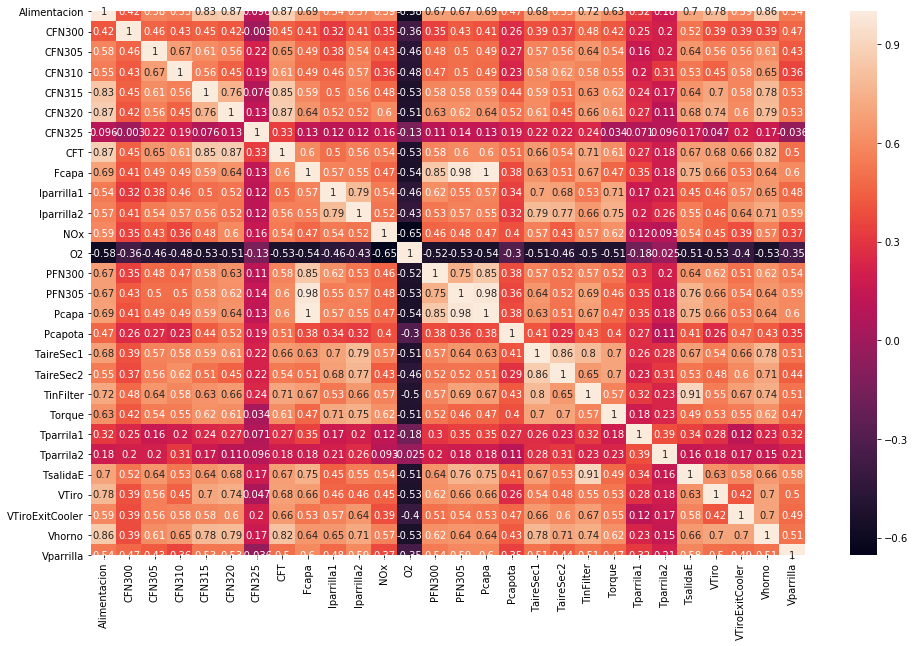

In [19]:
corrMatrix = base_data.corr(method = 'spearman')

plt.subplots(figsize = (16,10))
sn.heatmap(corrMatrix, annot=True)

Por definición del sistema $TaireSec1$ es espejo de $TaireSec2$ (variable a predecir), por lo que debería retirarse para no generar redundancia en el sistema de variables. Esta remoción es también justificada por el alto nivel de correlación expuesta en la gráfica anterior

In [20]:
base_data = base_data.drop(['TaireSec1'] , axis = 1)

In [21]:
cols_feat.remove('TaireSec1')

In [22]:
# Create lagging for columns

lags = 20
for c_feat in cols_feat:
    for i in range(1, lags + 1):
        base_data[c_feat + f'_{i}'] = base_data[c_feat].shift(- 1 * i)

In [23]:
# Create moving average

for c_feat in cols_feat:    
    base_data[c_feat + '_mean'] = (base_data[c_feat + '_1'] +  base_data[c_feat + '_2'] +  base_data[c_feat + '_3'])/3

In [24]:
# No functional data - cells
base_data = base_data.dropna()

In [25]:
x_cols = list(base_data.columns)
x_cols.remove(*cols_output)

In [26]:
n_estimators = 100

x = base_data[x_cols].values
y = base_data[cols_output].values[:,-1]

regressor = RandomForestRegressor(n_estimators = n_estimators, random_state = 0)  
regressor.fit(x, y)

fi = pd.DataFrame({'feature': x_cols,
               'importance': regressor.feature_importances_}).\
                sort_values('importance', ascending = False).reset_index(drop = True)

In [33]:
cols_rel = [x[0] for x in fi.values[0:20]]

In [89]:
fi.iloc[0:30]

,feature,importance
0,TinFilter,0.388293
1,TinFilter_1,0.172057
2,TinFilter_2,0.108347
3,TinFilter_mean,0.063836
4,TinFilter_3,0.046078
5,TinFilter_4,0.036678
6,TinFilter_6,0.027487
7,TinFilter_7,0.027356
8,Iparrilla2_mean,0.024380
9,TinFilter_8,0.018040


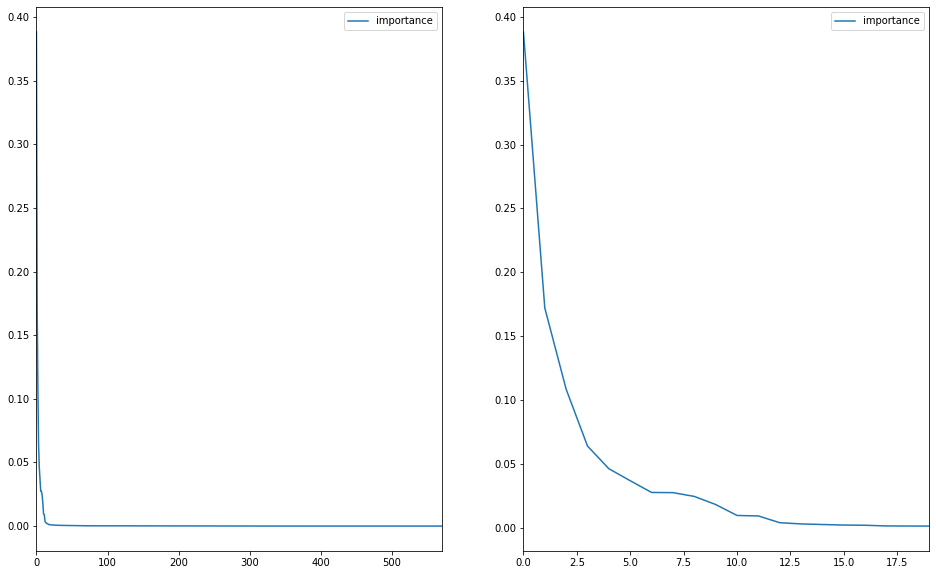

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (16,10))

fi.plot(ax = ax[0], y = 'importance')
fi.iloc[0:20].plot(ax = ax[1], y = 'importance')

Según los resultados previos se identifican los <tt>features</tt> más relevantes dados los niveles de pureza entregados por el árbol, de los cuales se seleccionan los 20 primeros para efectos de entrenamiento

In [35]:
models = {
            'linear':
            {
                'mod' : LinearRegression(),
                'par' : {}
            },
            'svm' :
            {
                'mod' : SVR(),
                'par' : 
                {
                    'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
                    'gamma' : ('scale', 'auto')    
                }
            },
            'tree' :
            {
                'mod' : DecisionTreeRegressor(splitter = 'best'),
                'par' :
                {
                    'criterion' : ('mse', 'friedman_mse', 'mae')
                }
            },
            'network' :
            {
                'mod' : MLPRegressor(warm_start = True),
                'par' :
                {
                    'hidden_layer_sizes' : [(20,), (50,), (100,)],
                    'activation' : ('logistic',),
                    'solver' : ('lbfgs', 'sgd', 'adam')
                }
            }
        }

In [36]:
def grid(base_path, now_date, path_file, os_X_tt, os_Y_tt, models, score = 'roc_auc', cv = 50, n_proc = 2):    
    
    for name in models:
        logger.info('*'*80)
        logger.info("Model: " + name)
        t_beg = time.time()
       
        pipeline = Pipeline([('scaler', StandardScaler()), (name,  models[name]['mod'])])
        parameters = {}          
        for par in models[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = models[name]['par'][par]
        aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc, scoring = score, verbose=2, cv = cv)
        aux.fit(os_X_tt, os_Y_tt)
        models[name]['bestModel'] = aux.best_estimator_
        models[name]['mae'] = aux.best_score_
       
        selection_time = time.time() - t_beg
       
        models[name]['selection_time'] = selection_time
       
        sample_f_path = os.path.join(base_path, path_file, f'{name}_{now_date.strftime("%Y%m%d_%H%M")}.sav')
       
        logger.info(f"Saving model at {sample_f_path}")    
        joblib.dump(models[name]['bestModel'], sample_f_path)
       
        logger.info(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        logger.info(f"El error score de la familia {name} es: {models[name]['mae']:0.3f}")
        logger.info('*'*80)
       
    mod_name = None
    best_mae = -np.inf
    for name in models:
        if models[name]['mae'] > best_mae:
            mod_name = name
            best_mae = models[name]['mae']

    logger.info(f"best model was: {mod_name} with an error of: {best_mae}")
    
    return models, mod_name

In [37]:
# Splitting training and testing dfs

X_train, X_test, Y_train, Y_test = train_test_split(base_data[cols_rel], base_data[cols_output], 
                                                    test_size = 0.2, shuffle=False)

In [58]:
# Saving training and testing results

sqlite_name = f"Proc_{now_date.strftime('%Y%m%d_%H%M')}"

train_df = pd.concat([X_train, Y_train], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)


save_sqlite(base_path, 
            os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
            train_df, sqlite_name, 'training')

save_sqlite(base_path, 
            os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
            test_df, sqlite_name, 'testing')

INFO:root:Saving results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200227_0803.sqlite3
INFO:root:Saving results en C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\Proc_20200227_0803.sqlite3


Se hace uso de la métrica *r2* o la función de scoring para la regresión, ello dado el objetivo de obtener el modelo que mejor reduzca el error medio cuadrático

In [38]:
models, selected = grid(base_path, now_date, os.path.join(base_path, projekt, 'data_sources', data_source, 'res'),
                        X_train, column_or_1d(np.ravel(Y_train), warn = True), models, 
                        score = 'r2', cv = 50, n_proc = 4)

INFO:root:********************************************************************************
INFO:root:Model: linear
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.9s finished
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
INFO:root:Saving model at C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\linear_20200227_0803.sav
INFO:root:El tiempo de seleccion fue: 11.095 s
INFO:root:El error score de la familia linear es: -106.659
INFO:root:********************************************************************************
INFO:root:********************************************************************************
INFO:root:Model: svm
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 c

Fitting 50 folds for each of 8 candidates, totalling 400 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 11.8min
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 47.4min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 107.1min
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed: 121.0min finished
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
INFO:root:Saving model at C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM089

Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    9.1s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed: 26.0min finished
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
INFO:root:Saving model at C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\tree_20200227_0803.sav
INFO:root:El tiempo de seleccion fue: 1657.363 s
INFO:root:El error score de la familia tree es: -4.697
INFO:root:********************************************************************************
INFO:root:********************************************************************************
INFO:root:Model: network
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 c

Fitting 50 folds for each of 9 candidates, totalling 450 fits


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.1min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 28.0min
[Parallel(n_jobs=4)]: Done 450 out of 450 | elapsed: 37.1min finished
C:\Users\orios\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
INFO:root:Saving model at C:\Users\orios\OneDrive - Cementos Argos S.A\Documentos\Projekte\0. Bitacora\Master\CM0891\CM0891\data_sources\ds3_DIGITAL\res\network_20200227_0803.sav
INFO:root:El tiempo de seleccion fue: 2251.843 s
INFO:root:El error score de la familia network es: -3.883
INFO:root:********************************************************************************
INFO:root:best model was: network with an er

El modelo seleccionado dada la métrica de interés es el modelo (que contiene el respectivo *scaler*) con label {{ selected }} con los siguientes parámetros:

In [46]:
models[selected]['bestModel']

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('network',
                 MLPRegressor(activation='logistic', alpha=0.0001,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=False, epsilon=1e-08,
                              hidden_layer_sizes=(100,),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_iter=200,
                              momentum=0.9, n_iter_no_change=10,
                              nesterovs_momentum=True, power_t=0.5,
                              random_state=None, shuffle=True, solver='lbfgs',
                              tol=0.0001, validation_fraction=0.1,
                              verbose=False, warm_start=True))],
         verbose=False)

In [62]:
if 'models' not in locals():
    model_toload = 'network_20200227_0803'
    model_loaded = carga_model(base_path, 
                               os.path.join(base_path, projekt, 'data_sources', data_source, 'res'), 
                               model_toload)
    
else:
    model_loaded = models[selected]['bestModel']

In [78]:
X_test_scaled = model_loaded[0].transform(X_test)
Y_pred = model_loaded[1].predict(model_loaded[0].transform(X_test))

In [84]:
print('Mean squared error : {:.3f}'.format(mean_squared_error(Y_test, Y_pred)))

Mean squared error : 6762.224


In [80]:
print('Mean absolute error : {:.3f}'.format(mean_absolute_error(Y_test, Y_pred)))

Mean absolute error : 70.195
